## Cells per Spot Stats

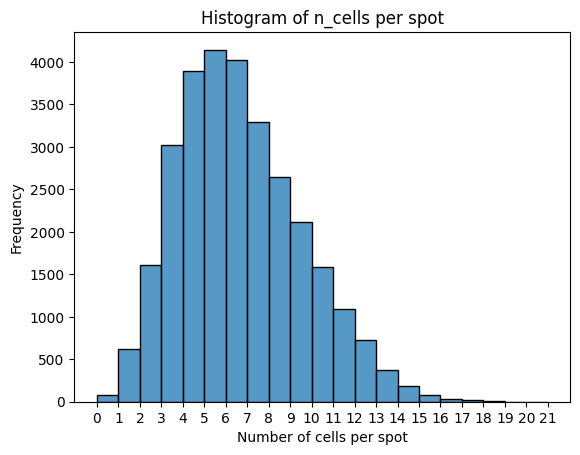

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


data_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\Cell_Segmentation"

dfs = []
for sample in os.listdir(data_dir):
    df = pd.read_csv(os.path.join(data_dir,sample, f"{sample}_tissue_positions_list.csv"), index_col=0)
    dfs.append(df)

dfs = pd.concat(dfs)
dfs.head()

# Filter the DataFrame where 'spot_image_name' is not None
filtered_df = dfs[dfs['spot_image_name'].notna()]

# Define integer bins based on the range of the data
min_val = filtered_df['n_segmented_cells'].min()
max_val = filtered_df['n_segmented_cells'].max()
bins = np.arange(min_val, max_val + 2)  # Add 2 to include the last integer value

# Create the histogram
sns.histplot(data=filtered_df, x='n_segmented_cells', bins=bins, kde=False)

# Customize x-axis ticks to show only integers
plt.xticks(bins)
plt.xlabel('Number of cells per spot')
plt.ylabel('Frequency')
plt.title('Histogram of n_cells per spot')
plt.show()



In [2]:
dfs

,pos,y,x,real_y,real_x,spot_image_name,n_segmented_cells
ACGCCTGACACGCGCT-1,0,0,0,11903,9001,NaN,0
TACCGATCCAACACTT-1,0,1,1,11846,8903,NaN,0
ATTAAAGCGGACGAGC-1,0,0,2,11790,9001,NaN,0
GATAAGGGACGATTAG-1,0,1,3,11734,8904,NaN,0
GTGCAAATCACCAATA-1,0,0,4,11678,9001,NaN,0
...,...,...,...,...,...,...,...
GAACGTTTGTATCCAC-1,0,77,123,990,1825,NaN,0
ATTGAATTCCCTGTAG-1,0,76,124,934,1922,NaN,0
TACCTCACCAATTGTA-1,0,77,125,878,1825,NaN,0
AGTCGAATTAGCGTAA-1,0,76,126,822,1922,NaN,0


## Use UNI for Feature Extraction

In [24]:
import timm
import os
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import torch 


local_dir = '../repos/UNI'
model = timm.create_model(
    "vit_large_patch16_224", img_size=224, patch_size=16, init_values=1e-5, num_classes=0, dynamic_img_size=True
)
model.load_state_dict(torch.load(os.path.join(local_dir, "pytorch_model.bin"), map_location="cpu"), strict=True)
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): 

In [ ]:
from PIL import Image

image = Image.open(os.path.join(local_dir, "uni.jpg"))
image = transform(image).unsqueeze(dim=0) # Image (torch.Tensor) with shape [1, 3, 224, 224] following image resizing and normalization (ImageNet parameters)
with torch.inference_mode():
    feature_emb = model(image) # Extracted features (torch.Tensor) with shape [1,1024]

In [ ]:
import os
import torch
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from timm import create_model
from timm.data import resolve_data_config, create_transform

# Initialize and load the model
model = create_model(
    "vit_large_patch16_224", img_size=224, patch_size=16, init_values=1e-5, num_classes=0, dynamic_img_size=True
)
model.load_state_dict(torch.load(os.path.join(local_dir, "pytorch_model.bin"), map_location="cpu"), strict=True)
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
model.eval()

def extract_features(image_path):
    """Extracts feature embeddings from an image using the ViT model."""
    image = Image.open(image_path)
    image = transform(image).unsqueeze(dim=0)  # Transform and add batch dimension
    with torch.inference_mode():
        feature_emb = model(image)  # Extracted feature tensor
    return feature_emb.squeeze().cpu().numpy()

# Load your dataset of ROIs (each item should have an image path and a label)
data = [
    {"path": "path/to/roi1.jpg", "label": 0},
    {"path": "path/to/roi2.jpg", "label": 1},
    # Add more ROI paths and labels here
]

# Extract features for all ROIs
X = [extract_features(item["path"]) for item in data]
y = [item["label"] for item in data]

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. ROI Classification with Logistic Regression ###
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {accuracy_log_reg}")

### 2. ROI Classification with k-NN ###
knn = KNeighborsClassifier(n_neighbors=3)  # Adjust n_neighbors as needed
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"k-NN Classifier Accuracy: {accuracy_knn}")

### 3. ROI Classification with Nearest Centroid (SimpleShot) ###
nearest_centroid = NearestCentroid()
nearest_centroid.fit(X_train, y_train)
y_pred_centroid = nearest_centroid.predict(X_test)
accuracy_centroid = accuracy_score(y_test, y_pred_centroid)
print(f"Nearest Centroid Classifier (SimpleShot) Accuracy: {accuracy_centroid}")

### 4. Slide Classification with Multiple Instance Learning (MIL) ###
# Assuming `slide_data` contains the image paths and slide labels
slide_data = [
    {"slide_id": "slide1", "roi_paths": ["path/to/roi1.jpg", "path/to/roi2.jpg"], "label": 0},
    {"slide_id": "slide2", "roi_paths": ["path/to/roi3.jpg", "path/to/roi4.jpg"], "label": 1},
    # Add more slide entries with their respective ROIs and labels
]

def mil_slide_classification(slide_data, classifier):
    """
    Performs Multiple Instance Learning (MIL) for slide classification.
    Each slide is represented by a bag of feature embeddings (from ROIs).
    """
    slide_features, slide_labels = [], []

    for slide in slide_data:
        # Extract features for all ROIs in the slide
        roi_features = [extract_features(path) for path in slide["roi_paths"]]
        bag_feature = np.mean(roi_features, axis=0)  # Mean-pooling over ROIs
        slide_features.append(bag_feature)
        slide_labels.append(slide["label"])

    # Train-test split for slide-level classification
    X_train, X_test, y_train, y_test = train_test_split(slide_features, slide_labels, test_size=0.2, random_state=42)

    # Apply classifier on slide-level features
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Using logistic regression for MIL slide classification
mil_accuracy = mil_slide_classification(slide_data, log_reg)
print(f"MIL Slide Classification Accuracy: {mil_accuracy}")


tensor([[ 0.0783,  0.2866,  1.0306,  ..., -0.7856,  1.0857,  0.3346]])

## Segment Cells from H&E Image

In [4]:
import pandas as pd
import numpy as np
import tifffile
import random
import string
import os
import pandas as pd
import numpy as np
import tifffile
import random
import string
import os
import numpy as np
import matplotlib.pyplot as plt
import squidpy as sq
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from PIL import Image
from matplotlib.patches import Ellipse
import shutil


def stardist_2D_versatile_he(img, nms_thresh=None, prob_thresh=None):
    #axis_norm = (0,1)   # normalize channels independently
    axis_norm = (0, 1, 2)  # normalize channels jointly
    # Make sure to normalize the input image beforehand or supply a normalizer to the prediction function.
    # this is the default normalizer noted in StarDist examples.
    img = normalize(img, 1, 99.8, axis=axis_norm)
    model = StarDist2D.from_pretrained("2D_versatile_he")
    labels, _ = model.predict_instances(
        img, nms_thresh=nms_thresh, prob_thresh=prob_thresh
    )
    return labels

# Function to create a random string for filenames
def random_string(length=8):
    letters = string.ascii_letters
    return ''.join(random.choice(letters) for i in range(length))


def segment_cells_from_image(image_dir, image, tissue_positions_df, sample_name):
    output_dir = os.path.join(image_dir, sample_name)
    output_spots_dir = os.path.join(output_dir, f"{sample_name}_spots")
    segmentation_dir = os.path.join(output_dir, f"{sample_name}_segmentation")
    plots_dir = os.path.join(output_dir, f"{sample_name}_plots")

    # shutil.rmtree(output_spots_dir)
    # shutil.rmtree(segmentation_dir)
    # shutil.rmtree(plots_dir)

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(output_spots_dir, exist_ok=True)
    os.makedirs(segmentation_dir, exist_ok=True)
    os.makedirs(plots_dir, exist_ok=True)


    alpha_channel = np.ones((image.shape[0], image.shape[1]), dtype=np.uint8) * 255
    image_array = np.dstack((image, alpha_channel))


    # Column to store image names
    tissue_positions_df["spot_image_name"] = ""
    tissue_positions_df["n_segmented_cells"] = 0


    # Loop through tissue positions to create and save cropped ellipse regions
    for idx, row in tissue_positions_df.iterrows():
        if row["pos"] == 1:
            # Ellipse parameters
            dam_x = int(55 * 98.0 / 100)  # Width of the oval
            dam_y = int(55 * 112.0 / 100)  # Height of the oval
            center_x, center_y = int(row['real_x']), int(row['real_y'])

            # Calculate bounding box coordinates for cropping
            x_min = max(center_x - dam_x // 2, 0)
            x_max = min(center_x + dam_x // 2, image_array.shape[1])
            y_min = max(center_y - dam_y // 2, 0)
            y_max = min(center_y + dam_y // 2, image_array.shape[0])

            # Crop the region from the original image
            cropped_region = image_array[y_min:y_max, x_min:x_max]

            # Create an elliptical mask with transparency
            y_indices, x_indices = np.ogrid[:cropped_region.shape[0], :cropped_region.shape[1]]
            ellipse_mask = (((x_indices - dam_x // 2) ** 2) / (dam_x // 2) ** 2 +
                            ((y_indices - dam_y // 2) ** 2) / (dam_y // 2) ** 2) <= 1



            # Generate random filename, save to DataFrame
            image_name = f"{random_string()}"
            tissue_positions_df.at[idx, "spot_image_name"] = image_name
            transparent_ellipse = np.zeros_like(cropped_region, dtype=np.uint8)
            transparent_ellipse[..., :3] = cropped_region[..., :3]  # Copy RGB channels
            transparent_ellipse[..., 3] = np.where(ellipse_mask, 255, 0)  # Set alpha channel
            output_image = Image.fromarray(transparent_ellipse, "RGBA")
            
            output_image.save(os.path.join(output_spots_dir, f"{image_name}.tiff"), "TIFF")  # Save with high DPI
            

            ## Segmentation
            crop = sq.im.ImageContainer(cropped_region[..., :3], layer="image")
            sq.im.segment(
                img=crop,
                layer="image",
                channel=None,
                method=stardist_2D_versatile_he,
                layer_added="segmented_stardist",
                prob_thresh=0.05,
                nms_thresh=0.4,
            )

            count_cell_array = np.squeeze(np.array(crop['segmented_stardist']))
            count_cell_array[~ellipse_mask] = 0
            tissue_positions_df.at[idx, "n_segmented_cells"] = len(np.unique(count_cell_array)) - 1


            fig, axes = plt.subplots(1, 2)
            crop.show("image", ax=axes[0])
            _ = axes[0].set_title("H&E")
            crop.show("segmented_stardist", cmap="jet", interpolation="none", ax=axes[1])
            _ = axes[1].set_title("segmentation")
            plt.savefig(os.path.join(plots_dir, f"{image_name}.pdf"))
            plt.close()

            # extent = axes[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            # fig.savefig(os.path.join(segmentation_dir, f"{image_name}.tiff"), format="TIFF", bbox_inches=extent, pad_inches=0)

            np.savez(os.path.join(segmentation_dir, f"{image_name}.npz"), segmented_array=count_cell_array)




    # Save the updated tissue_positions_df with image names
    tissue_positions_df.to_csv(os.path.join(output_dir, f"{sample_name}_tissue_positions_list.csv"))

In [ ]:
from pathlib import Path
import os
import pandas as pd
import tifffile

# Define directories using Pathlib
histology_dir = Path(r"D:\MorrissyLab Dropbox\Visium_profiling\visium_sequencing-data\2021_visium_round1_seq\hist-images")
tissues_dir = Path(r"D:\MorrissyLab Dropbox\Visium_profiling\morrissy-chan")
image_dir = Path(r"D:\mac-data\phd\Projects\SpatialTM\test_data")

# Pre-filter samples list
samples = [x.stem for x in histology_dir.glob("BT*.tif")]

samples_main_dirs = ["200616", "201126", "201204", "201210"]

# Process samples
for sample in samples:
    sample_tif = histology_dir / f"{sample}.tif"
    for samples_dir in samples_main_dirs:
        main_dir_path = tissues_dir / samples_dir
        if (main_dir_path / sample).exists():
            sample_path = main_dir_path / sample / "spatial" / "tissue_positions_list.csv"
            if sample_path.exists():
                
                print(f"Processing {sample}")
                # Read tissue positions CSV
                tissue_positions_df = pd.read_csv(sample_path, index_col=0, names=["pos", "y", "x", "real_y", "real_x"])

                # Load corresponding image
                image = tifffile.imread(sample_tif)

                segment_cells_from_image(image_dir, image, tissue_positions_df, sample_name= sample)
                

                # fig, ax = plt.subplots(figsize=(20, 20))  # Adjust the size as needed
                # ax.imshow(image, cmap='gray')

                # # Add circles based on DataFrame coordinates
                # for _, row in tissue_positions_df.iterrows():
                #     if(row["pos"]==1):
                #         dam_x = 55 * 98.0/100   # Width of the oval
                #         dam_y = 55 * 112.0/100  # Height of the oval
                #         x, y = row['real_x'], row['real_y']
                #         oval = Ellipse((x, y), width=dam_x, height=dam_x, edgecolor='red', facecolor='none', linewidth=0.5)
                #         ax.add_patch(oval)
                # # Display the result
                # # Hide axes and display the result
                # plt.axis('off')
                # output_dir = os.path.join(image_dir, sample)
                # os.makedirs(output_dir, exist_ok=True)
                # plt.savefig(os.path.join(output_dir, f"{sample}_spots.pdf"))
                # plt.close()

Processing BT143_y3_128d_i_0um_ctrl
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Processing BT143_z4_105d_i_0um_ctrl
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*
